In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP')
import yaml
import numpy as np
from torch import Tensor
import torch
import matplotlib.pyplot as plt
from run_experiments.prepare_dataset import *
from utils_general import prepare_common_background_info, pred4all_outputs_inputs, evaluate_on_single_output, plot_traindata_testdata_fittedgp, neg_log_likelihood
from code_blocks.our_models.lvmogp_svi import LVMOGP_SVI
from code_blocks.likelihoods.gaussian_likelihood import GaussianLikelihood

In [2]:
config_name = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/configs/synthetic/Scale_RBF/lvmogp_50_outputs_unfix.yaml'
model_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/synthetic/Scale_RBF/lvmogp_50_outputs_unfix/2024-02-23_09:53:52/model.pth'
likelihood_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/experiments_results/synthetic/Scale_RBF/lvmogp_50_outputs_unfix/2024-02-23_09:53:52/likelihood.pth'

## Load in model

In [3]:
with open(config_name) as file:
    config = yaml.safe_load(file)

my_model = LVMOGP_SVI(
        n_outputs = config['n_outputs'],
        n_input = config['n_input_train'],                    # NOTE PAY ATTENTION, not total n_inputs.
        input_dim = config['input_dim'],
        latent_dim = config['latent_dim'],
        n_inducing_input = config['n_inducing_input'],
        n_inducing_latent = config['n_inducing_latent'],
        learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
        learn_inducing_locations_input = config['learn_inducing_locations_input'],
        latent_kernel_type = config['latent_kernel_type'],
        input_kernel_type = config['input_kernel_type'],
        trainable_latent_dim = config['trainable_latent_dim'] if 'trainable_latent_dim' in config else None,
        latent_first_init = None,                # if None, random initialization
        latent_second_init = None,               # if None, random initialization
        NNEncoder = config['NNEncoder'],
        layers = None                                         # if none, adopt default value [4, 8, 4]
    )

my_likelihood = GaussianLikelihood()

In [4]:
model_state_dict = torch.load(model_path)
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(likelihood_path)
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

## Look at latent variables

In [25]:
my_model.X.q_log_sigma.data = my_model.X.q_log_sigma.detach() - 1000.

In [26]:
my_model.X.q_log_sigma.exp()

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<ExpBackward0>)

## Load in dataset

In [27]:
if config['dataset_type'] == 'synthetic_regression':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls = prepare_synthetic_regression_data(config)
        means, stds = None, None
        
n_data4visual = 500
inputs_total4visual = Tensor(np.linspace(config['min_input_bound'], config['max_input_bound'], n_data4visual))

In [28]:
common_background_information = prepare_common_background_info(my_model, config)

## Test via integration

In [29]:

all_pred_mean, all_pred_var = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=data_inputs,
                                                        config=config,
                                                        common_background_information=common_background_information,
                                                        approach='integration')


100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


In [30]:
all_pred_mean4visual, all_pred_var4visual = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=inputs_total4visual,
                                                        config=config,
                                                        common_background_information=common_background_information,
                                                        approach='integration',
                                                        not4visual=False,
                                                        n_data4visual=n_data4visual)


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


### Metrices

In [31]:
train_data_predict = all_pred_mean[train_sample_idx_ls]
train_rmse = (train_data_predict - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via integration', train_rmse)

w_test_data_predict = all_pred_mean[test_sample_idx_ls]
test_rmse = (w_test_data_predict - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via integration', test_rmse)


Global Train RMSE via integration tensor(0.2604)
Global Test RMSE via integration tensor(0.4158)


In [32]:
train_nll = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean[train_sample_idx_ls], GaussianVar=all_pred_var[train_sample_idx_ls])
test_nll = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean[test_sample_idx_ls], GaussianVar=all_pred_var[test_sample_idx_ls])

print('Global Train negative log likelihood via integration:', train_nll)
print('Global Test negative log likelihood via integration:', test_nll)

Global Train negative log likelihood via integration: tensor(nan)
Global Test negative log likelihood via integration: tensor(nan)


### Loop over all function index

In [33]:
train_rmse_list = [] # list of tensors
test_rmse_list = []
train_nll_list = []
test_nll_list = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_single_output(
                                                        function_index = output_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed,
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean,
                                                        all_pred_var = all_pred_var,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual,
                                                        all_pred_var4visual = all_pred_var4visual                                                        
                                                        )
    train_rmse_list.append(performance_dirct['train_rmse'])
    test_rmse_list.append(performance_dirct['test_rmse'])
    train_nll_list.append(performance_dirct['train_nll'])
    test_nll_list.append(performance_dirct['test_nll'])

In [34]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [35]:
print('The output index with WORSE test rmse performance: ', test_rmse_list.index(max(test_rmse_list)))
print('The output index with WORSE test nll performance: ', test_nll_list.index(max(test_nll_list)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list.index(min(test_rmse_list)))
print('The output index with BEST test nll performance: ', test_nll_list.index(min(test_nll_list)))

The output index with WORSE test rmse performance:  28
The output index with WORSE test nll performance:  44
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 42
The output index with MIDDLE test nll performance: 45
------------------------------------------------------------
The output index with BEST test rmse performance:  32
The output index with BEST test nll performance:  6


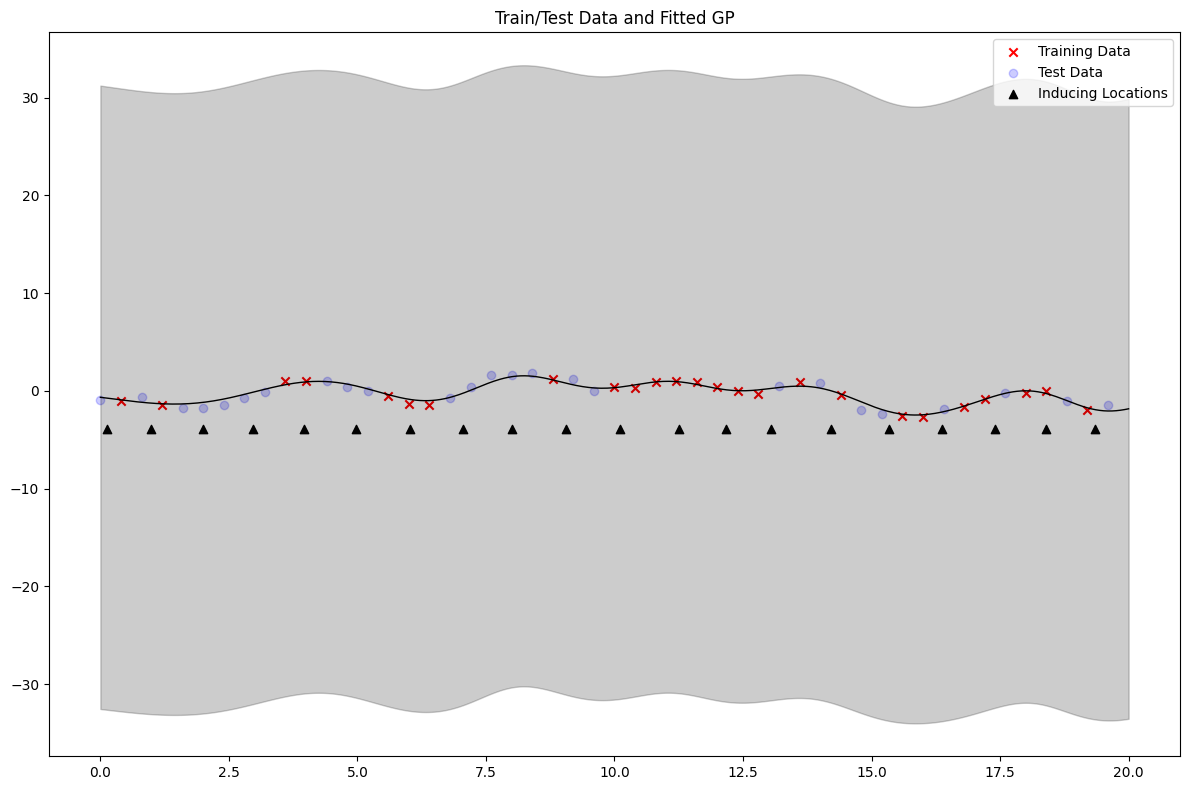

In [36]:
function_index = 0
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(
                                                        function_index = function_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed, 
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean,
                                                        all_pred_var = all_pred_var,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual,
                                                        all_pred_var4visual = all_pred_var4visual                                                        
)
picture_save_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/func_id_{function_index}_numofoutput_{config["n_outputs"]}.png'
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=inputs_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_input.data, n_inducing_C=config['n_inducing_input'], picture_save_path=picture_save_path) # NOTE: input is C not X

## Test via mean

In [17]:
all_pred_mean_, all_pred_var_ = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=data_inputs,
                                                        config=config,
                                                        approach='mean')

In [18]:
all_pred_mean4visual_, all_pred_var4visual_ = pred4all_outputs_inputs(my_model=my_model,
                                                        my_likelihood=my_likelihood,
                                                        data_inputs=inputs_total4visual,
                                                        config=config,
                                                        approach='mean',
                                                        not4visual=False,
                                                        n_data4visual=n_data4visual)

In [19]:
train_data_predict_ = all_pred_mean_[train_sample_idx_ls]
train_rmse_ = (train_data_predict_ - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE via mean', train_rmse_)

w_test_data_predict_ = all_pred_mean_[test_sample_idx_ls]
test_rmse_ = (w_test_data_predict_ - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE via mean', test_rmse_)

Global Train RMSE via mean tensor(0.2604)
Global Test RMSE via mean tensor(0.4158)


In [20]:
train_nll_ = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean_[train_sample_idx_ls], GaussianVar=all_pred_var_[train_sample_idx_ls])
test_nll_ = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean_[test_sample_idx_ls], GaussianVar=all_pred_var_[test_sample_idx_ls])

print('Global Train negative log likelihood via mean:', train_nll_)
print('Global Test negative log likelihood via mean:', test_nll_)

Global Train negative log likelihood via mean: tensor(0.2107)
Global Test negative log likelihood via mean: tensor(0.5237)


### Loop over all function index

In [21]:
train_rmse_list_ = [] # list of tensors
test_rmse_list_ = []
train_nll_list_ = []
test_nll_list_ = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_single_output(
                                                        function_index = output_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed,
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean_,
                                                        all_pred_var = all_pred_var_,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual_,
                                                        all_pred_var4visual = all_pred_var4visual_                                                        
                                                        )
    train_rmse_list_.append(performance_dirct['train_rmse'])
    test_rmse_list_.append(performance_dirct['test_rmse'])
    train_nll_list_.append(performance_dirct['train_nll'])
    test_nll_list_.append(performance_dirct['test_nll'])

In [22]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [23]:
print('The output index with WORSE test rmse performance: ', test_rmse_list_.index(max(test_rmse_list_)))
print('The output index with WORSE test nll performance: ', test_nll_list_.index(max(test_nll_list_)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list_))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list_))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list_.index(min(test_rmse_list_)))
print('The output index with BEST test nll performance: ', test_nll_list_.index(min(test_nll_list_)))

The output index with WORSE test rmse performance:  28
The output index with WORSE test nll performance:  28
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 42
The output index with MIDDLE test nll performance: 24
------------------------------------------------------------
The output index with BEST test rmse performance:  32
The output index with BEST test nll performance:  32


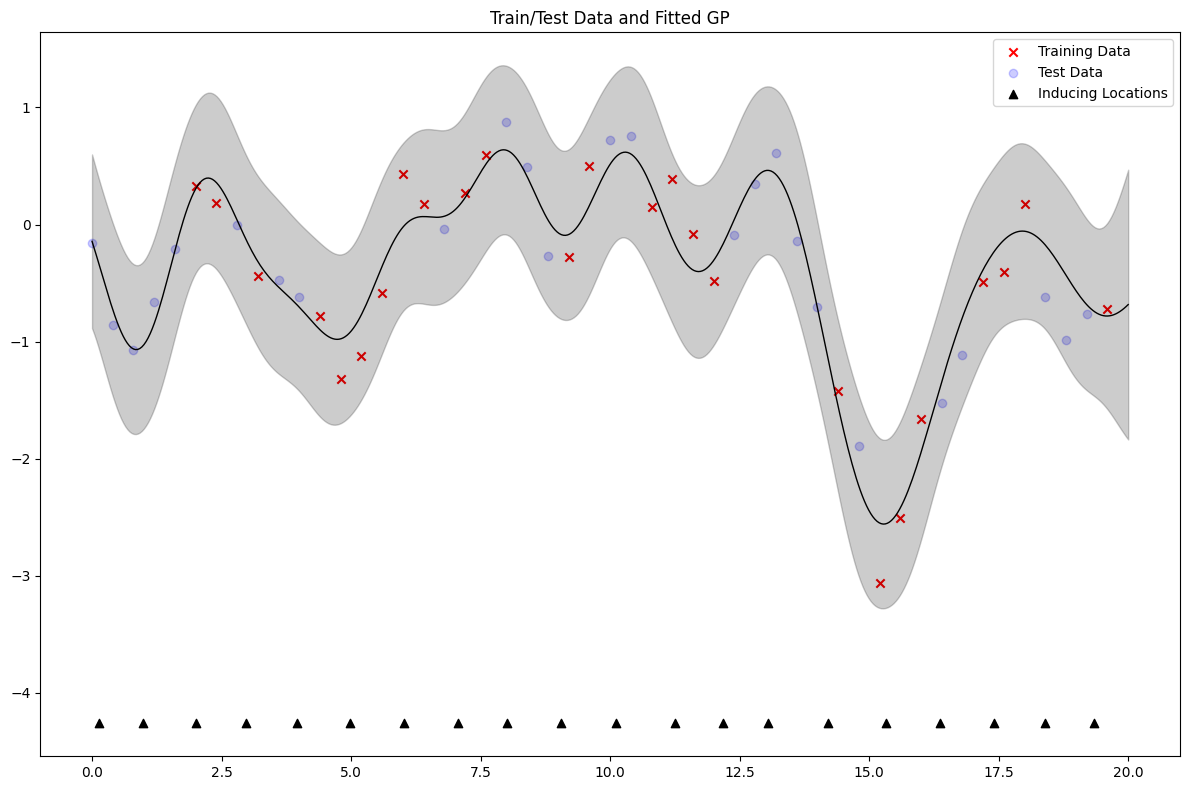

In [24]:
function_index = 32
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_single_output(
                                                        function_index = function_index,
                                                        data_inputs = data_inputs,
                                                        data_Y_squeezed = data_Y_squeezed, 
                                                        ls_of_ls_train_input = ls_of_ls_train_input,
                                                        ls_of_ls_test_input = ls_of_ls_test_input,
                                                        train_sample_idx_ls = train_sample_idx_ls,
                                                        test_sample_idx_ls = test_sample_idx_ls,
                                                        all_pred_mean = all_pred_mean_,
                                                        all_pred_var = all_pred_var_,
                                                        n_data4visual = n_data4visual,
                                                        all_pred_mean4visual = all_pred_mean4visual_,
                                                        all_pred_var4visual = all_pred_var4visual_                                                        
)
picture_save_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/func_id_{function_index}_numofoutput_{config["n_outputs"]}.png'
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=inputs_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_input.data, n_inducing_C=config['n_inducing_input'], picture_save_path=picture_save_path) # NOTE: input is C not X